### DATA Augmentation multiclass implementation 
J. Cristiano

Resources:

https://gist.github.com/interactivetech/c2913317603b79c02ff49fa9824f1104

https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#sphx-glr-auto-examples-transforms-plot-transforms-e2e-py





In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.datasets.coco import CocoDetection

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [3]:
coco_root = '/work/2024_annot/images'
coco_annFile = '/work/2024_annot/2024_annotations.json'
standard_transform = transforms.v2.Compose([
    v2.CenterCrop(2048), 
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
vanilla_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
vanilla_dataset = datasets.wrap_dataset_for_transforms_v2(vanilla_dataset, target_keys=( "labels", "masks"))

idx = random.randint(0, len(vanilla_dataset) - 1)
image, target = vanilla_dataset[idx]


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [4]:
augmentations = transforms.v2.Compose([
    transforms.v2.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.v2.RandomRotation(degrees=5)
])

Random Perspective
Random Affine
Random Horizontal Flip
Color Jitter
Gaussian Blur
Random Rotation


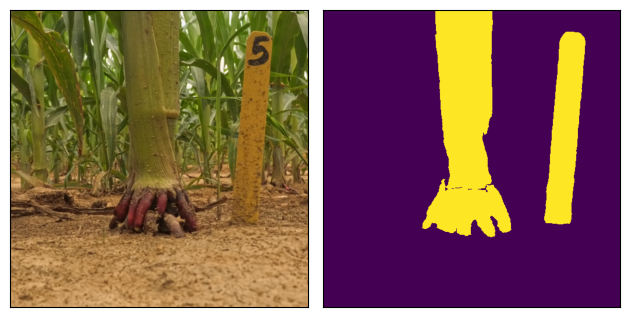

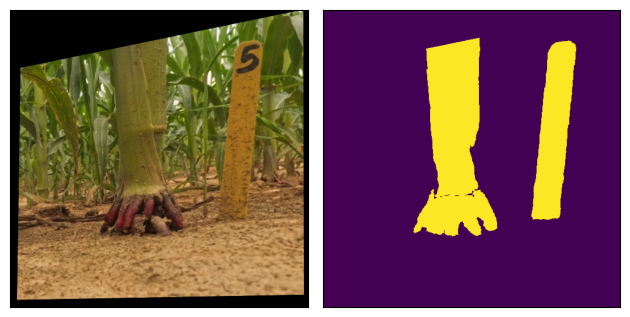

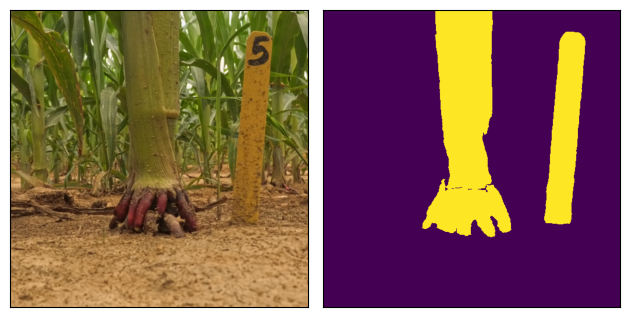

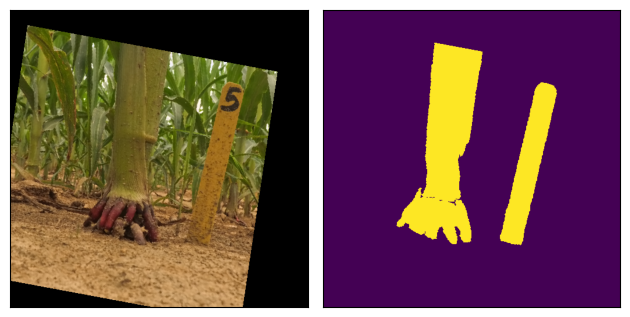

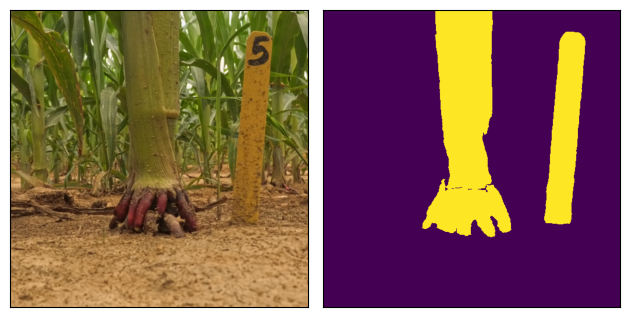

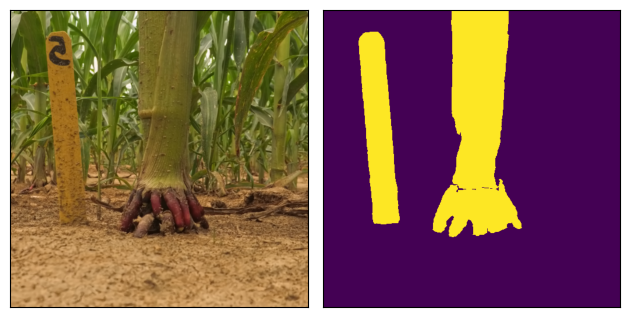

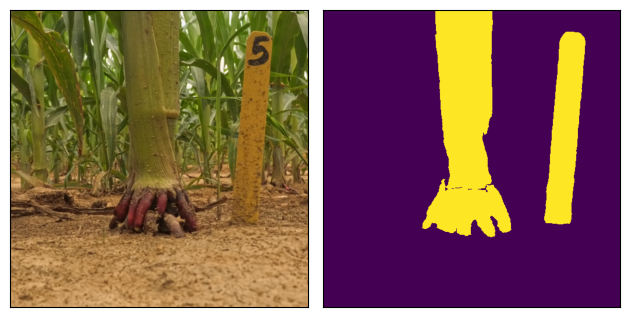

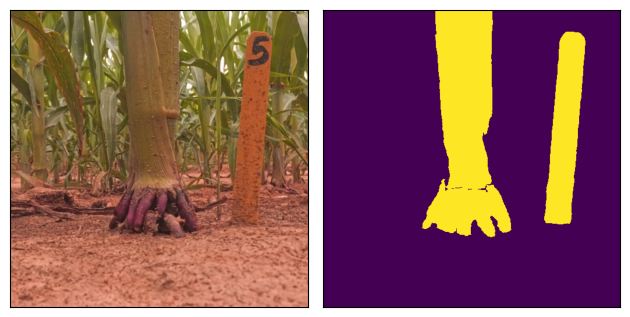

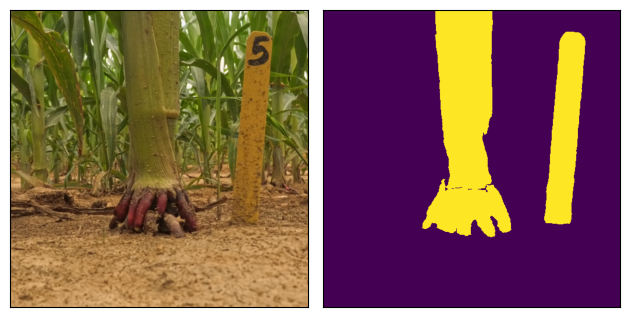

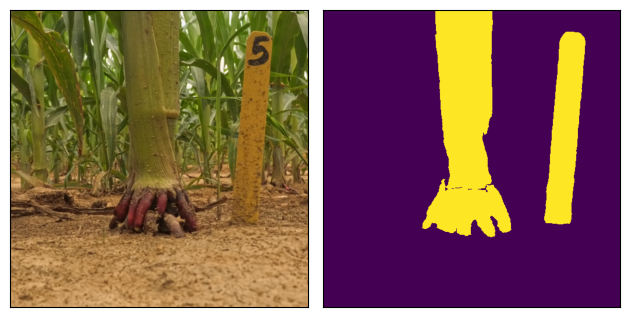

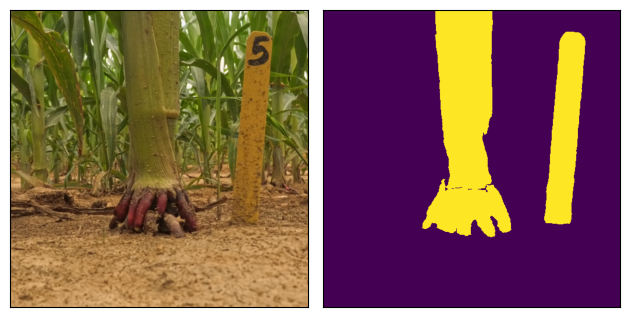

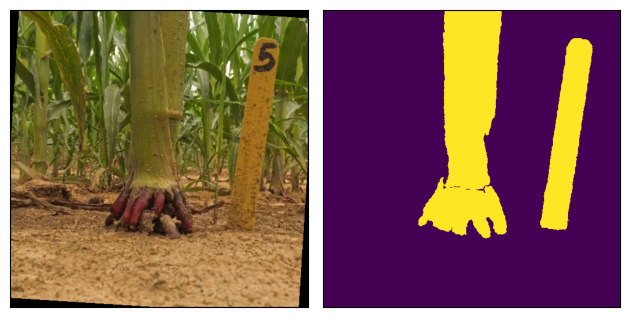

In [5]:
transformations = {
    "Random Perspective": transforms.v2.RandomPerspective(distortion_scale=0.5, p=1.0),
    "Random Affine": transforms.v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    "Random Horizontal Flip": transforms.v2.RandomHorizontalFlip(p=1.0),
    "Color Jitter": transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    "Gaussian Blur" : transforms.v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    "Random Rotation": transforms.v2.RandomRotation(degrees=5),
    
}
for name, transform in transformations.items():
    # Apply the transformation to the original image
    combined_mask = torch.max(target["masks"], dim=0)[0]
    plot([image, combined_mask])
    transformed_image, transformed_mask = transform(image, target)
    transformed_mask = torch.max(transformed_mask["masks"], dim=0)[0]
    # transformed_mask = transform(combined_mask.unsqueeze(0))
    print(name)
    plot([transformed_image,transformed_mask])

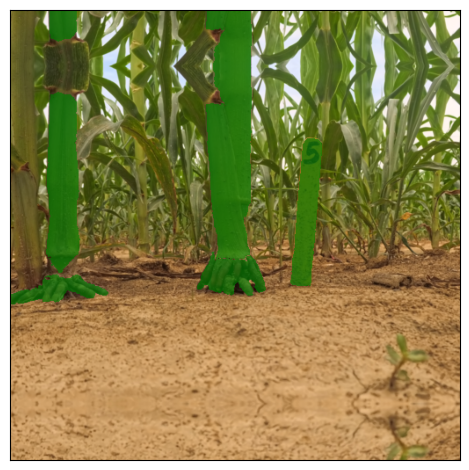

In [11]:
os.chdir("/work")
from PadSquare import PadSquare
vanilla_dataset.transforms = transforms.v2.Compose([
    PadSquare(padding_mode="symmetric"),
    v2.Resize((512, 512)),
    v2.ToImage()
])
plot([vanilla_dataset[idx]] )

In [7]:
# import segmentation_models_pytorch as smp
# from segmentation_models_pytorch.encoders import get_preprocessing_fn
# import torch.nn as nn


# preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
# model = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=4,                      # model output channels (number of classes in your dataset)
# )
# def custom_collate_fn(batch):
#     # Unpack the batch - assuming each item is a (image, mask) tuple
#     images, masks = zip(*batch)
#     mask_batch = []
#     for mask in masks:
#         multiclass_mask = torch.zeros((4, mask["masks"].shape[1], mask["masks"].shape[2]), dtype=mask["masks"].dtype)
#         for idx, label in enumerate(mask["labels"]):
#             multiclass_mask[label] = mask["masks"][idx]
#         multiclass_mask[0] = 1 - torch.max(multiclass_mask[1:], dim=0)[0]
#         mask_batch.append(multiclass_mask)

#     return images, mask_batch

# #TODO: Add Weights
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# vanilla_dataset.transforms = transforms.v2.Compose([standard_transform, augmentations])
# dataloader = DataLoader(
#     vanilla_dataset, 
#     batch_size=4, 
#     shuffle=True, 
#     num_workers=2,
#     collate_fn=custom_collate_fn)
# training_results = {
#     "train_loss": [],
#     "test_loss" : [],  
#     "pocket_loss": [],
#     "pocket_model": None,
# }
# for epoch in range(3):
#     running_loss = 0.0
#     for img, mask in dataloader:
#         model.train()
#         img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
#         img = img.permute(0, 3, 1, 2).float()
#         result = model(img)
#         mask = torch.stack(mask)
#         loss = criterion(result, mask.float())
#         running_loss += loss.item()
#         # print(loss.item())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     # print(len(dataloader))
#     training_results["train_loss"].append(running_loss/len(dataloader))
#     print(f"Epoch {epoch} - Loss: {training_results['train_loss'][-1]}")



# # plot([img, combined_mask])
# # plot(result.squeeze().detach().cpu().numpy())


In [8]:
# model.eval()
# image, target = vanilla_dataset[5]
# image = torch.tensor(preprocess_input(image.permute(1, 2, 0).numpy()))
# image = image.permute(2, 0, 1).unsqueeze(0).float()
# result = model(image)
# plot(image, row_title=["Original Image"])
# plot(result.squeeze().detach().cpu().numpy(), row_title=["Predicted Mask"])